In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

C:\Users\user\miniconda3\envs\ml\lib\site-packages\requests\__init__.py:78: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({0}) or chardet ({1}) doesn't match a supported "


In [2]:
DEVICE = 'cpu'

In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
train_dataset = datasets.CIFAR10(root = "../data/CIFAR10",
                                      train = True,
                                      download = True,
                                      transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = "../data/CIFAR10",
                                     train = False,
                                     transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [5]:
train,target =  train_dataset[0]
print(train.shape,  target)
np.transpose(train,(1,2,0)).shape

torch.Size([3, 32, 32]) 6


torch.Size([32, 32, 3])

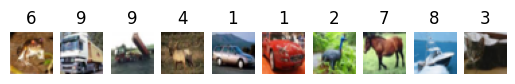

In [6]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
# train 데이터를 10개만 가져오자
for cnt, (x,y) in enumerate(train_dataset):
    if cnt >= 10: break 
    plt.subplot(1,10,cnt+1)
    plt.axis('off')
    # TypeError: Invalid shape (3, 32, 32) for image data
    plt.imshow(np.transpose(x, (1,2,0)))    
    plt.title(y)




In [27]:
# 분류 100 설계  MLP
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,10)
    def forward(self,x):
        x = x.view(-1,32*32*3)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x      


In [28]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [51]:
# model.train()  전체 레이어를 사용 : 전체 layer의 전원을 켠다
# model.eval() evaluation, 사용하지 않는 layer들의 전원을 끈다
from tqdm import tqdm # 진행상황을 progress bar로 표시
def train(model, train_loader,optimizer):
    model.train()
    for image, label in tqdm(train_loader):  # 배치단위로 출력
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        print(f"output : {output.shape}")
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

In [52]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.*correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [53]:
for epoch in range(1, EPOCHS+1):
    train(model,train_loader,optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(f"epoch : {epoch}  loss : {test_loss}, accuracy : {test_accuracy}")

  0%|▏                                                                | 6/1563 [00:00<00:26, 59.56it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


  1%|▊                                                               | 20/1563 [00:00<00:24, 62.10it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


  2%|█▍                                                              | 34/1563 [00:00<00:24, 61.99it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


  3%|██                                                              | 49/1563 [00:00<00:22, 67.99it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


  4%|██▋                                                             | 65/1563 [00:00<00:21, 70.57it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


  5%|███▎                                                            | 81/1563 [00:01<00:20, 70.87it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


  6%|████                                                            | 98/1563 [00:01<00:20, 71.67it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


  7%|████▌                                                          | 113/1563 [00:01<00:21, 67.86it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


  8%|█████▏                                                         | 128/1563 [00:01<00:21, 67.69it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


  9%|█████▍                                                         | 135/1563 [00:02<00:22, 63.63it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


  9%|█████▉                                                         | 148/1563 [00:02<00:25, 54.45it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


 10%|██████▍                                                        | 160/1563 [00:02<00:26, 52.93it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


 11%|██████▋                                                        | 166/1563 [00:02<00:26, 53.35it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


 11%|███████▏                                                       | 178/1563 [00:02<00:27, 50.22it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


 12%|███████▋                                                       | 190/1563 [00:03<00:27, 50.73it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


 13%|████████▏                                                      | 202/1563 [00:03<00:26, 52.12it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


 13%|████████▍                                                      | 208/1563 [00:03<00:26, 51.60it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


 14%|████████▊                                                      | 220/1563 [00:03<00:27, 48.61it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


 15%|█████████▍                                                     | 233/1563 [00:03<00:24, 55.10it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


 16%|█████████▉                                                     | 246/1563 [00:04<00:24, 54.42it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


 17%|██████████▍                                                    | 258/1563 [00:04<00:24, 52.55it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


 17%|██████████▉                                                    | 271/1563 [00:04<00:24, 53.70it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


 18%|███████████▏                                                   | 277/1563 [00:04<00:24, 52.36it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


 18%|███████████▋                                                   | 289/1563 [00:05<00:24, 52.06it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


 19%|████████████▏                                                  | 301/1563 [00:05<00:24, 51.47it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


 20%|████████████▌                                                  | 313/1563 [00:05<00:24, 50.51it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


 21%|█████████████▏                                                 | 326/1563 [00:05<00:22, 55.49it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


 22%|█████████████▌                                                 | 338/1563 [00:05<00:22, 54.02it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


 22%|██████████████                                                 | 350/1563 [00:06<00:23, 52.23it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


 23%|██████████████▋                                                | 364/1563 [00:06<00:19, 60.67it/s]

output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


 24%|███████████████                                                | 375/1563 [00:06<00:20, 57.39it/s]


output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])
output : torch.Size([32, 10])


KeyboardInterrupt: 

In [54]:
# CNN 모델 설계
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=8,kernel_size=3
        )
        self.conv2 = nn.Conv2d(
            in_channels=8, out_channels=16,kernel_size=3
        )
        self.pool = nn.MaxPool2d(
            kernel_size=2
        )
        self.fc1 = nn.Linear(100352,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,10)
    
    def forward(self, x):   # 3,32,32                        
        x = self.conv1(x)  # (8,30,30)
        
        x = F.relu(x)
        x = self.conv2(x)  # 16, 28, 28
        
        x = F.relu(x)
        x = self.pool(x)  # [ 16, 14, 14]
        print(x.shape)
        x = x.view(-1,16*14*14*32)  # 16*14*14 = 3136
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x  
        
        

In [55]:
cnnModel = CNN().to(DEVICE)
optimizer = torch.optim.Adam(cnnModel.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()
for epoch in range(1, EPOCHS+1):
    train(cnnModel,train_loader,optimizer)
    test_loss, test_accuracy = evaluate(cnnModel, test_loader)
    print(f"epoch : {epoch}  loss : {test_loss}, accuracy : {test_accuracy}")

  0%|                                                                         | 0/1563 [00:00<?, ?it/s]

torch.Size([32, 16, 14, 14])
output : torch.Size([1, 10])


ValueError: Expected input batch_size (1) to match target batch_size (32).